In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.plot_prediction import plot_total_force, plot_force_components
from scipy.optimize import least_squares
import logging
log = logging.getLogger(__name__)
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ship}.tests")
test_smooth = catalog.load(f"{ship}.tests_ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
model_loaders = catalog.load(f"{ship}.models")
units = catalog.load(f"{ship}.units")

[07/20/23 17:09:47] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=170621;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=18911;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/20/23 17:09:56] INFO     Kedro project phd                                                      ]8;id=219717;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=560069;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=270977;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=795419;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=17344;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=476939;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=738028;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=941858;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.tests_ek_smooth' (PartitionedDataSet)...     ]8;id=349737;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=739134;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=876248;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=42407;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=343667;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=750111;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=945690;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=290881;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=382010;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=785538;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=130680;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=219908;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
model_loaders.keys()

dict_keys(['vmm_7m_vct.MDL_hull_inverse_dynamics', 'vmm_7m_vct.VCT_MDL_resistance', 'vmm_7m_vct_wind.MDL_hull_inverse_dynamics', 'vmm_7m_vct_wind.VCT_MDL_resistance', 'vmm_martins_simple.MDL_hull_inverse_dynamics', 'vmm_martins_simple.VCT_MDL_resistance', 'vmm_martins_simple_thrust.MDL_inverse_dynamics', 'vmm_simple.VCT_MDL_resistance', 'vmm_simple_wind.VCT_MDL_resistance'])

In [77]:
#model_wind = model_loaders["vmm_simple.VCT_MDL_resistance"]()
#model_wind = model_loaders["vmm_7m_vct.MDL_hull_inverse_dynamics"]()
model_wind = model_loaders["vmm_7m_vct.VCT_MDL_resistance"]()

In [78]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

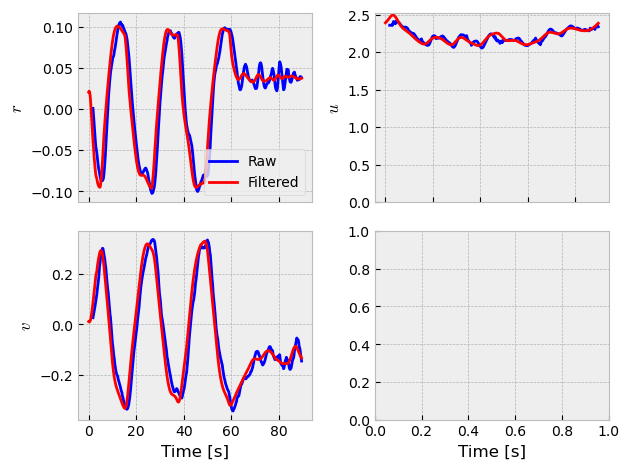

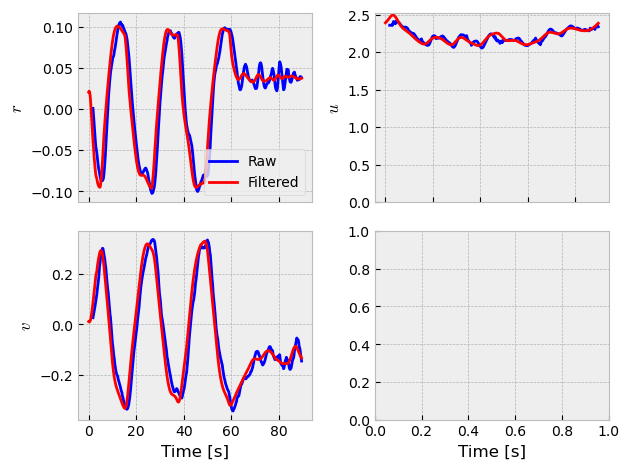

In [79]:
id = '0'
loader = time_series[id]
data_raw = loader()
loader = test_smooth[id]
data = loader()

#track_plots(dataframes={'Raw':data_raw, 'Filtered':data}, lpp=ship_data['L'], beam=ship_data['B'])
dataframes={'Raw':data_raw.select_dtypes(exclude='object').rolling(window=10).mean(), 'Filtered':data}
plot(dataframes, keys=['u','v','r'])

In [113]:
id = '1'
model_wind.parameters['kappa']=0.5
loader = test_smooth[id]
data = loader()
data["rev"] = 15.5
data["delta"]+=np.deg2rad(1.8)
#data['twa'] = mean_angle(data['twa'])
data.drop(columns=['mission','date'], inplace=True)

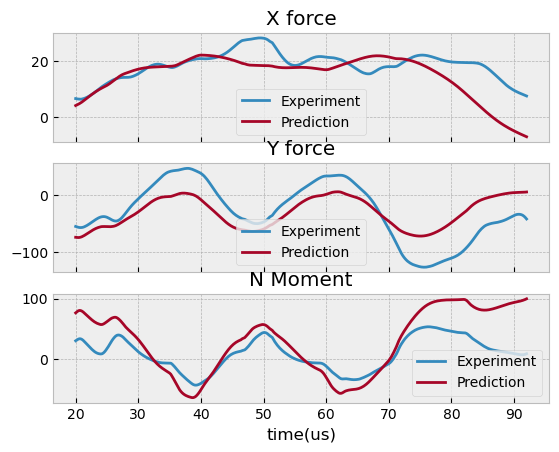

In [114]:
plot_total_force(model=model_wind, data=data, window=100);

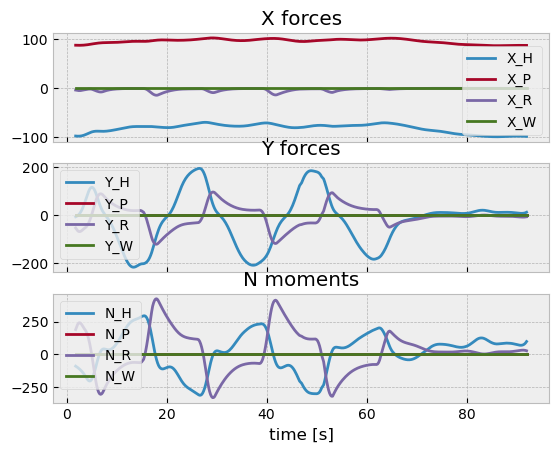

In [115]:
plot_force_components(model=model_wind, data=data, window=10);

In [116]:
result_wind = model_wind.simulate(data)

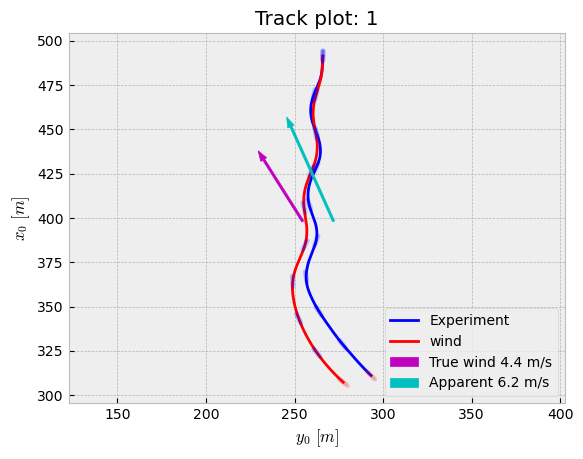

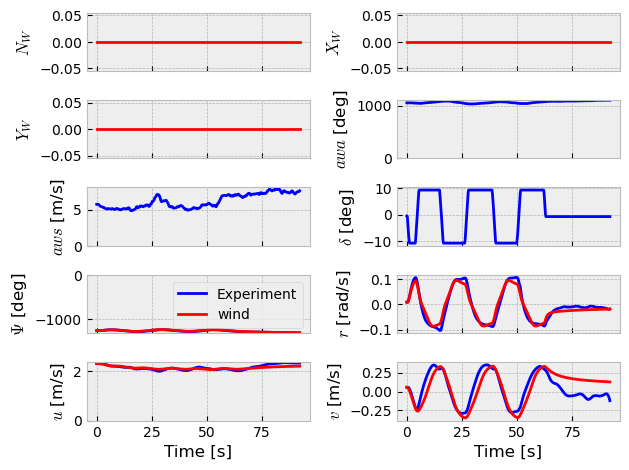

In [117]:
dataframes = {
    'Experiment':data,
    'wind':result_wind
}

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=10);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','X_W','Y_W','N_W'], time_window=time_window, units=units, symbols=symbols_dict);

## Compare models

In [41]:
model_names = [
    "vmm_7m_vct.VCT_MDL_resistance",
    "vmm_7m_vct.MDL_hull_inverse_dynamics"
]

models = {name:model_loaders[name]() for name in model_names}

In [42]:
for name, model in models.items():
    pass

In [43]:
df_force = model.forces_from_motions(data=data)
df_force["X_D"] = df_force['fx']
df_force["Y_D"] = df_force['fy']
df_force["N_D"] = df_force['mz']

force_predicted = {}
for name,model in models.items():
    force_predicted[name] = pd.DataFrame(model.calculate_forces(states_dict=data[model.states_str], control=data[model.control_keys]))

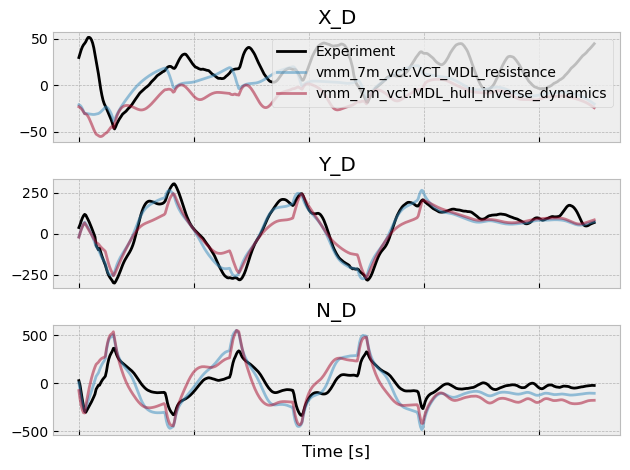

In [44]:
fig, axes = plt.subplots(nrows=3)

for dof,ax in zip(["X_D","Y_D","N_D"],axes):
    
    ax.set_title(dof)
    df_force.plot(y=dof, label="Experiment", style='k-', ax=ax)
    for name, df_force_predicted in force_predicted.items():
        df_force_predicted.plot(y=dof, label=name, alpha=0.5, ax=ax)
    
    ax.set_xticklabels([])
    ax.set_xlabel("")
    ax.get_legend().set_visible(False)

axes[0].legend(loc='upper right')
axes[-1].set_xlabel('Time [s]')
plt.tight_layout()

In [45]:
_ = []
for name, df_force_predicted in force_predicted.items():
    s = pd.Series(name=name)
    for dof in ["X_D","Y_D","N_D"]:
        s[dof] = r2_score(y_true=df_force[dof], y_pred=df_force_predicted[dof])
    _.append(s)        
    
scores=pd.DataFrame(_)
scores['total'] = scores.mean(axis=1)

In [46]:
scores

,X_D,Y_D,N_D,total
vmm_7m_vct.VCT_MDL_resistance,-0.726987,0.935611,0.042143,0.083589
vmm_7m_vct.MDL_hull_inverse_dynamics,-2.059600,0.857616,-0.408446,-0.536810


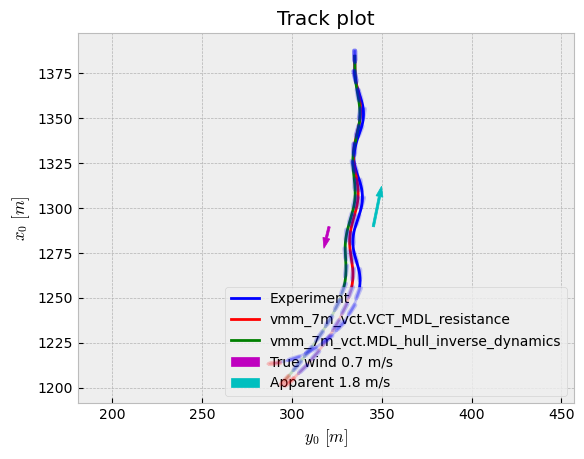

In [47]:
dataframes = {
    'Experiment':data,
}

for name,model in models.items():
    dataframes[name] = model.simulate(data)

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);

